In [1]:
import pywavefront
# from pywavefront import visualization
# import pyglet
# # import ratcave as rc
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy as sp
import pandas as pd

from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import linalg
from scipy import spatial

import networkx as nx
import openmesh as om
import copy

# from open3d.cpu.pybind.geometry import HalfEdge

from collections import deque
import heapq


from rectpack import float2dec, newPacker,PackingBin
import rectangle_packing_solver as rps


%matplotlib notebook

In [785]:
class Point():
    def __init__(self,index=None,coordinates=[None,None,None]):
        self.index=index
        self.x=coordinates[0]
        self.y=coordinates[1]
        self.z=coordinates[2]
        self.u=None
        self.v=None
        self.chart=None
        self.neighbors=[]
        self.nus=[]
        self.nvs=[]
        
    def copy(self,other):
        self.index=other.index
        self.x=other.x
        self.y=other.y
        self.z=other.z
        self.u=other.u
        self.v=other.v
        self.chart=other.chart
        self.neighbors=other.neighbors

        
    def __str__(self):
        s="Point at "+"["+str(self.x)+","+str(self.y)+","+str(self.z)+"]"
        return s

In [786]:
def make_cloud(scene):
    vertices=scene.vertices
    pointcloud=[Point(i,vertices[i]) for i in range(len(vertices))]    
    face=scene.mesh_list[0].faces 
    return vertices,pointcloud,face

In [787]:
def normalise(vec):
    return vec/np.linalg.norm(vec)

In [788]:
class Face():
    def __init__(self,pointcloud,pointcloud_full,list_points):
        self.index=[list_points[0],list_points[1],list_points[2]]
        
        self.v1=pointcloud_full[list_points[0]]
        self.v2=pointcloud_full[list_points[1]]
        self.v3=pointcloud_full[list_points[2]]
    def local_coordinates(self):
        self.coords=[] #[x1,y1],[x2,y2],[x3,y3] -> [0,0],[x2,0],[x3,y3]
        
        vec_1=np.array([self.v1.x,self.v1.y,self.v1.z])
        vec_2=np.array([self.v2.x,self.v2.y,self.v2.z])
        vec_3=np.array([self.v3.x,self.v3.y,self.v3.z])     
        
        bary=np.mean([vec_1,vec_2,vec_3],axis=0)     
        
        vec_21=vec_2-vec_1
        vec_x=normalise(vec_21)
        
        
        vec_31=vec_3-vec_1
        vec_n=np.cross(vec_x,vec_31)
        vec_n=normalise(vec_n)
        vec_y=np.cross(vec_n,vec_x)
        vec_y=normalise(vec_y)
        
        
        vec_bary=bary-vec_1
        
        x2=vec_21@vec_x
        # self.coords.append([x2,0])

        x3=vec_31@vec_x
        y3=vec_31@vec_y
        # self.coords.append([x3,y3])
        pos_bary=[vec_bary@vec_x,vec_bary@vec_y]   
        
        self.x1=0
        self.y1=0
        self.x2=x2
        self.y2=0
        self.x3=x3
        self.y3=y3
        
        self.coords=[[self.x1,self.y1],[self.x2,self.y2],[self.x3,self.y3]]
    def calculate_area(self):
        self.area=abs(self.x1*self.y2-self.y1*self.x2+self.x2*self.y3-self.y2*self.x3+self.x3*self.y1-self.y3*self.x1)
        
    def calculate_W(self):
        self.W1=complex(self.x3-self.x2,self.y3-self.y2)
        self.W2=complex(self.x1-self.x3,self.y1-self.y3)
        self.W3=complex(self.x2-self.x1,self.y2-self.y1)
        self.W=[self.W1,self.W2,self.W3]

In [789]:
def distance(pa,pb):
    return np.sqrt((pa.x-pb.x)**2+(pa.y-pb.y)**2+(pa.z-pb.z)**2)

In [790]:
def longest_distance(pointcloud):
    pts=[]
    for point in pointcloud:
        pts.append([point.x,point.y,point.z])
    # print(pts[0])
    # print(spatial.ConvexHull(pts).vertices[0])
    candidates = [pts[i] for i in spatial.ConvexHull(pts, qhull_options="QJ").vertices]
    dist_mat = spatial.distance_matrix(candidates, candidates)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    return [i,j]

In [791]:
def make_links(pointcloud,pointcloud_full,faces):
    facecloud=[]
    for face in faces:
        f=Face(pointcloud,pointcloud_full,face)
        f.local_coordinates()
        f.calculate_area()
        f.calculate_W()
        facecloud.append(f)
        for v1 in face:
            for v2 in face:
                point1=pointcloud_full[v1]
                point2=pointcloud_full[v2]
                if not point2 in point1.neighbors and v2 !=v1:
                    point1.neighbors.append(point2)
    return facecloud

In [792]:
def make_pins(pointcloud,pointlist,values):
# Up is the vector of pinned coordinates
    for i in range(len(pointlist)):       
        pointcloud[pointlist[i]].u=values[2*i]
        pointcloud[pointlist[i]].v=values[2*i+1]
        # print(pointcloud[pointlist[i]].u)


In [793]:
def set_pins(pc):
    pin_vertex=longest_distance(pc)
    coords=[]
    
    for point_id in pin_vertex:
        point=pc[point_id]
        # print(point)
        coords.append(point.x)
        coords.append(point.y)
        coords.append(point.z)
    extreme=min(coords)
    pin_vertex=[0,1]
    make_pins(pc,pin_vertex,[-extreme,-extreme,extreme,extreme])
    return pin_vertex,extreme

In [794]:
def draw3d(pc,point_size,line_width,color_v='b',color_e='r'):
    fig = plt.figure()
    ax = Axes3D(fig,auto_add_to_figure=False)
    ax.get_proj=lambda: np.dot(Axes3D.get_proj(ax),np.diag([0.5,0.5,1,1]))
    fig.add_axes(ax)
    for point in pc: 
        ax.scatter3D(point.x, point.y, point.z,s=point_size,c=color_v) 
        if point.index<4:
            ax.text(point.x, point.y, point.z,point.index) 
        for p2 in point.neighbors:
            ax.plot([point.x,p2.x],[point.y,p2.y],[point.z,p2.z],c=color_e,linewidth=line_width)
    # ax.plot([pointcloud[0].x,pointcloud[3].x],[pointcloud[0].y,pointcloud[3].y],[pointcloud[0].z,pointcloud[3].z],c='g')
    ax.set_title('3d Scatter plot')
    # ax.axis("auto")
    plt.show()

In [795]:
def pin_matrix(pointcloud,pointlist):
    cp=[]
    # print(pointlist)
    for point in pointlist:
#         print(point)
#         print(pointcloud[point].u)
#         print(pointcloud[point].v)
        cp.append(complex(pointcloud[point].u,pointcloud[point].v))
    U_p=np.array(cp).reshape((-1,1))
    return U_p
# U_p=np.array([complex(pointcloud[0].u,pointcloud[0].v),complex(pointcloud[1].u,pointcloud[1].v),complex(pointcloud[2].u,pointcloud[2].v),complex(pointcloud[3].u,pointcloud[3].v)]).reshape((-1,1))

In [796]:
def LSCM(vertices,faces):
    n_f=len(faces)
    n_v=len(vertices)

    M_p=np.zeros((n_f,n_v),dtype=complex)
    for i in range(n_f):
        face_temp=faces[i]
        for j in range(3):
            M_p[i,face_temp.index[j]]=face_temp.W[j]/np.sqrt(face_temp.area)            
    return M_p

In [797]:
def split_mat(M,pointlist):
    # print(pointlist)
#     print("M")
#     print(M)
    M_p=M[:,pointlist]
#     print("Mp")
#     print(M_p)
    M_f=np.delete(M,pointlist,axis=1)
#     print("Mf")
#     print(M_f)
    
    return M_p,M_f

In [798]:
def build_mat(M_f,M_p,U_p):
    M_f1=M_f.real
    M_f2=M_f.imag
    M_p1=M_p.real
    M_p2=M_p.imag
    U_p1=U_p.real    
    U_p2=U_p.imag
    
    A_1=np.hstack([M_f1,-1*M_f2])
    A_2=np.hstack([M_f2,M_f1])
    A=np.vstack([A_1,A_2])
    
    b_1=np.hstack([M_p1,-1*M_p2])
    b_2=np.hstack([M_p2,M_p1])
    b=-1*np.vstack([b_1,b_2])
    
    Up=np.vstack([U_p1,U_p2])  

    b=b@Up
    return A,b

In [799]:
def solve(A,b):
#     A=csr_matrix(A)
#     b=csr_matrix(b)
    # res=sp.sparse.linalg.inv(A.T@A)@A.T@b
    # res=np.linalg.inv(A.T@A)@A.T@b
    res=np.linalg.pinv(A.T@A)@A.T@b
    return res

In [800]:
def update_uv(pc,uv):
    for point in pc:
        if point.u!=None:
            continue
        point.u=uv.T[0][point.index-2]
        point.v=uv.T[0][point.index-2+int(len(uv)/2)]



In [801]:
def draw(pointcloud,pointsize=1,draw_lines=True,text=False):
    fig = plt.figure()
    ax = plt.axes()
    for point in pointcloud:
        ax.scatter(point.u,point.v,s=pointsize,c='b')
        if draw_lines:
            for nei in point.neighbors:
                ax.plot([point.u,nei.u],[point.v,nei.v],c='r')
        if text:
            ax.text(point.u,point.v,point.index)
    ax.axis("equal") 
    plt.show()
    


In [802]:
def projection(pointcloud,pointcloud_full,face):
    facecloud=make_links(pointcloud,pointcloud_full,face)
#     for f in facecloud:
#         print(f.coords)
    pin_vertex,diameter=set_pins(pointcloud)
#     print("pin "+str(pin_vertex))
#     print("D "+str(diameter))
#     for p in pointcloud:
#         print("u: "+str(p.u)+" v: "+str(p.v))
    U_p=pin_matrix(pointcloud,pin_vertex)
#     print(U_p)
    M=LSCM(pointcloud,facecloud)
    M_p,M_f=split_mat(M,pin_vertex)
    A,b=build_mat(M_f,M_p,U_p)
    uv=solve(A,b)
    update_uv(pointcloud,uv)

In [1195]:
scene_rabbit = pywavefront.Wavefront('meshes/fish3d/fish.obj',collect_faces=True,create_materials=True)
mesh_rabbit = om.read_trimesh("meshes/fish3d/fish.obj",vertex_normal=True,halfedge_status=True)
G_rabbit = nx.Graph()

Unimplemented OBJ format statement 's' on line 's 1'


In [1196]:
vertices_rabbit,pointcloud_rabbit,face_rabbit=make_cloud(scene_rabbit)
facecloud_rabbit=make_links(pointcloud_rabbit,pointcloud_rabbit,face_rabbit)

In [1197]:
def convexhull(pointcloud):
    pts=[]
    for point in pointcloud:
        pts.append([point.x,point.y,point.z])
    # print(pts[0])
    # print(spatial.ConvexHull(pts).vertices[0])
    candidates = [pointcloud[i] for i in spatial.ConvexHull(pts).vertices]
    return candidates

In [1198]:
print("total vertices: "+str(mesh_rabbit.n_vertices()))
print("total edges: "+str(mesh_rabbit.n_halfedges()))
print("total faces: "+str(mesh_rabbit.n_faces()))

total vertices: 212
total edges: 1260
total faces: 420


<IPython.core.display.Javascript object>


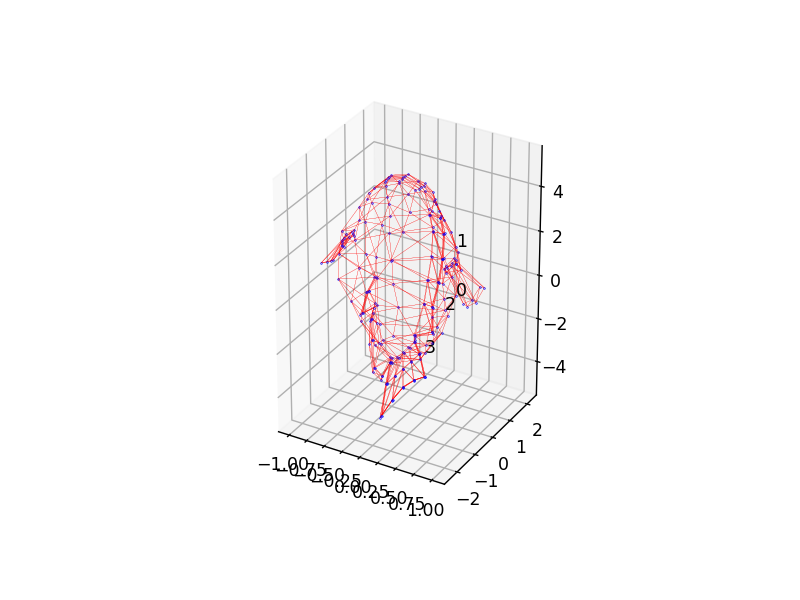

In [326]:
draw3d(pointcloud_rabbit,0.1,0.1)

In [1199]:
def calculate_normal(mesh):
    for h in mesh.halfedges():
        mesh.calc_halfedge_normal(h)
    for f in mesh.faces():
        mesh.calc_face_normal(f)

In [1200]:
calculate_normal(mesh_rabbit)

In [1201]:
def calculate_sharpeness(mesh,edge):
    edge_o=mesh.opposite_halfedge_handle(edge)
    face=mesh.face_handle(edge)
    face_o=mesh.face_handle(edge_o)
    if (face.idx()==-1 or face_o.idx()==-1):
        # print("boundary")
        return np.pi
    normal=mesh.normal(face)
    normal_o=mesh.normal(face_o)
    normal=normalise(normal)
    normal_o=normalise(normal_o)
    return np.arccos(normal@normal_o)

In [1202]:
def calculate_sharpeness_list(mesh,edges):
    if len(edges)==0:
        return 0.0
    s=0
    for edge in edges:
        s+=calculate_sharpeness(mesh,edge)
    return s

In [1203]:
def filter_edges(mesh,threshold):
    # remain=[]
    all_edges=[]
    for h in mesh.halfedges():
        all_edges.append([h,calculate_sharpeness(mesh,h)])
    all_edges.sort(key=lambda x:x[1],reverse=True)
    remain=[item[0] for item in all_edges[:int(len(all_edges)*threshold)]]
    return remain

In [1204]:
Tau=0.05

In [1205]:
detected_edges_rabbit=filter_edges(mesh_rabbit,Tau)

C:\Users\Junkai XIA\AppData\Local\Temp\ipykernel_1372\1193832014.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(normal@normal_o)


In [1206]:
def string_copy(s):
    cs=deque()
    for i in range(len(s)):
        cs.append(s[i])
    return cs

In [1207]:
def dfs(mesh, edge_current, S, sharpness_current, max_string_length,tau,feature,feature_neighbor,all_edges):
#     l=length_current
#     assert len(S)==l
#     if length_current == max_string_length:
#         return sharpness_current,copy(S)

    if len(S) == max_string_length:
        return sharpness_current,string_copy(S)
    edge_oppo=mesh.opposite_halfedge_handle(edge_current)
    S_iter=deque()
    sharpness_iter=sharpness_current
    vertex_temp=mesh.to_vertex_handle(edge_current)
    edge_neighbors=mesh.voh(vertex_temp)
#             for item in mesh.voh(vertex_temp):
#                 l_temp.append(item)
    for nei in edge_neighbors:
#         if (nei==edge_oppo) or (nei in feature_neighbor):
#             continue
        if (nei==edge_oppo) or (all_edges[nei.idx()]==1):
            continue
        S.append(nei)
#         l+=1
#         sharpness_nei=calculate_sharpeness(mesh,nei)
#         sharpness_prime,S_prime=dfs(mesh, nei, S, sharpness_current+sharpness_nei, l,\
#                                     max_string_length,tau,feature,feature_neighbor)  
#         S.pop()
#         l-=1
        sharpness_nei=calculate_sharpeness(mesh,nei)
        sharpness_prime,S_prime=dfs(mesh, nei, S, sharpness_current+sharpness_nei,\
                                    max_string_length,tau,feature,feature_neighbor,all_edges)  
        S.pop()
        if (sharpness_prime>sharpness_iter):
            sharpness_iter=sharpness_prime
            S_iter=string_copy(S_prime)
    return sharpness_iter,S_iter

In [1208]:
def add_neighbor_feature(mesh,edge,feature,feature_neighbor,all_edges):
    vt=mesh.to_vertex_handle(edge)
    edges_in=mesh.vih(vt)
    edges_out=mesh.voh(vt)
    for edge in edges_in:
#         if (not edge in feature) and (not edge in feature_neighbor):
#             feature_neighbor.append(edge)
        if all_edges[edge.idx()]==-1:
            feature_neighbor.append(edge)
            all_edges[edge.idx()]=1
    for edge in edges_out:
#         if (not edge in feature) and (not edge in feature_neighbor):
#             feature_neighbor.append(edge)
        if all_edges[edge.idx()]==-1:
            feature_neighbor.append(edge)
            all_edges[edge.idx()]=1
    

In [1209]:
def expand_feature_curve(mesh,start,min_feature_length,max_string_length,tau,feature,feature_neighbor):
    detected_feature=[]
    all_edges=[-1 for i in range(mesh.n_halfedges())]
    for h in [start,mesh.opposite_halfedge_handle(start)]:
        h_prime=h
        sharpness=0
        while True:
            S=deque()
            S.append(h_prime)
            sharpness_current=calculate_sharpeness(mesh,h_prime)
            sharpness,S=dfs(mesh, h_prime, S, sharpness_current,\
                             max_string_length,tau,feature,feature_neighbor,all_edges)
            if len(S)<2:
                
                break
            
            h_prime=S[1]
#             if h_prime in detected_feature:
#                 break
            if all_edges[h_prime.idx()]==0:
                break
            detected_feature.append(h_prime)
            all_edges[h_prime.idx()]=0
            
            if sharpness <= max_string_length * tau:
                break
    
    # print(len(detected_feature))           
    if len(detected_feature) > min_feature_length:
        # print("add to feature")
        for item in detected_feature:
            feature.append(item)
            
        h_o=mesh.opposite_halfedge_handle(detected_feature[0])
        add_neighbor_feature(mesh,h_o,feature,feature_neighbor,all_edges)
        for edge_feature in detected_feature:
            add_neighbor_feature(mesh,edge_feature,feature,feature_neighbor,all_edges)

In [1210]:
def detect_features(mesh,edges,t):
    max_string_length=3
    min_feature_length=5
    feature=[]
    feature_neighbor=[]
    tau=t
    i=0
    for start in edges:
        if i%100==0:
            print("finished "+str(i)+"/"+str(len(edges)))
        expand_feature_curve(mesh,start,min_feature_length,max_string_length,tau,feature,feature_neighbor)
        i+=1
    return feature,feature_neighbor

In [1211]:
feature_rabbit,feature_neighbor_rabbit=detect_features(mesh_rabbit,detected_edges_rabbit,Tau)

finished 0/63


C:\Users\Junkai XIA\AppData\Local\Temp\ipykernel_1372\1193832014.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(normal@normal_o)


In [1212]:
def save_features(feature,neighbor,file_feature_path,file_neighbor_path):
    l=[]
    ln=[]
    for f in feature:
        l.append(f.idx())
    for n in neighbor:
        ln.append(n.idx())
    l=np.array(l)
    ln=np.array(ln)
    np.save(file_feature_path,l)
    np.save(file_neighbor_path,ln)

In [1213]:
features_rabbit="features_fish.npy"
neighbors_rabbit="neighbors_fish.npy"


In [1214]:
save_features(feature_rabbit,feature_neighbor_rabbit,features_rabbit,neighbors_rabbit)

In [1215]:
def read_features(mesh,file_feature_path,file_neighbor_path):
    np_f=np.load(file_feature_path)
    np_n=np.load(file_neighbor_path)
    features=[]
    neighbors=[]
    for i in np_f:
        features.append(mesh.halfedge_handle(int(i)))
    for i in np_n:
        neighbors.append(mesh.halfedge_handle(int(i)))
    return features,neighbors
    

In [1216]:
feature_rabbit,feature_neighbor_rabbit=read_features(mesh_rabbit,features_rabbit,neighbors_rabbit)

In [1217]:
def feature_vertex(mesh,feature_edge,point_cloud):
    points=[]
    for edge in feature_edge:
        edge_o=mesh.opposite_halfedge_handle(edge)
        v=mesh.to_vertex_handle(edge)
        v_o=mesh.to_vertex_handle(edge_o)
        points.append([point_cloud[v.idx()],point_cloud[v_o.idx()]])
    return points

In [1218]:
feature_vertices_rabbit=feature_vertex(mesh_rabbit,feature_rabbit,pointcloud_rabbit)

In [1219]:
def draw_features(points_features,pc,size_point,width_line):
    fig = plt.figure()
    ax = Axes3D(fig,auto_add_to_figure=False)
    ax.get_proj=lambda: np.dot(Axes3D.get_proj(ax),np.diag([0.5,0.5,1,1]))
    fig.add_axes(ax)
    for point in pc: 
        
        ax.scatter3D(point.x, point.y, point.z,s=size_point,c='b') 
    for p2 in points_features:
        
        ax.plot([p2[0].x,p2[1].x],[p2[0].y,p2[1].y],[p2[0].z,p2[1].z],c='r',linewidth=width_line)
    # ax.plot([pointcloud[0].x,pointcloud[3].x],[pointcloud[0].y,pointcloud[3].y],[pointcloud[0].z,pointcloud[3].z],c='g')
    ax.set_title('features')
    plt.show()

<IPython.core.display.Javascript object>


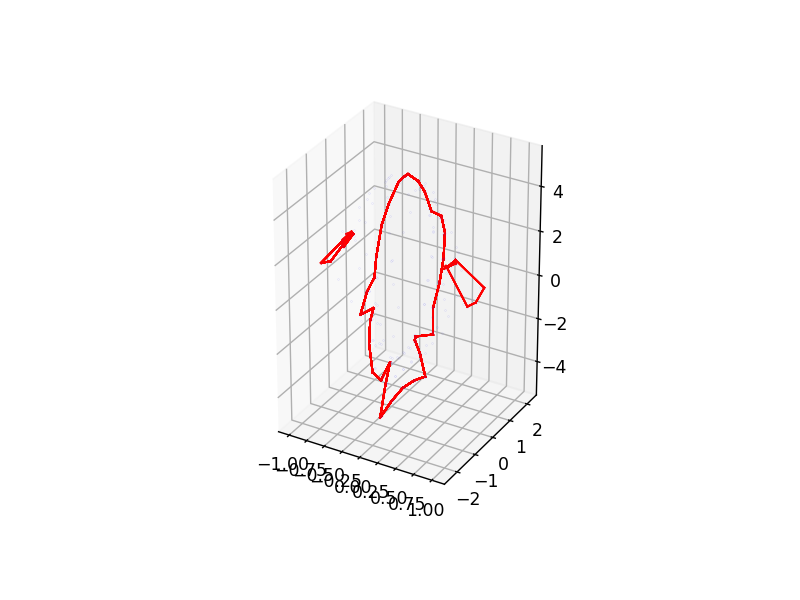

In [377]:
draw_features(feature_vertices_rabbit,pointcloud_rabbit,0.001,1)

In [1220]:
class Facet():    
    def __init__(self,mesh,index,facet):
        self.mesh=mesh
        self.index=index
        self.face=facet
        self.distance_to_feature=mesh.n_halfedges()
        self.vertices=[]
        self.edges=[]
        self.is_local_maximum=False
        self.chart=-1
        
    def __lt__(self,other):
        return self.distance_to_feature<other.distance_to_feature
        
    def get_ve(self):
        e=self.mesh.halfedge_handle(self.face)
        self.edges.append(e)
        self.vertices.append(self.mesh.to_vertex_handle(e))
        ne=self.mesh.next_halfedge_handle(e)
    
        while ne!=e:
            self.edges.append(ne)
            self.vertices.append(self.mesh.to_vertex_handle(ne))
            ne=self.mesh.next_halfedge_handle(ne)
       

In [1221]:
facets_rabbit=[Facet(mesh_rabbit,i,mesh_rabbit.face_handle(i)) for i in range(len(mesh_rabbit.faces()))]

In [1222]:
def construct_facets(mesh,facets):
    for f in facets:
        f.get_ve()

In [1223]:
construct_facets(mesh_rabbit,facets_rabbit)

In [1224]:
def get_facet(mesh,faces,edge):
    #print(mesh.face_handle(edge))
    #print(mesh.face_handle(edge).idx())
    return faces[mesh.face_handle(edge).idx()]

In [1225]:
def distance_to_features(mesh,facets,feature_edges):
        
    edges=deque()
    for e in feature_edges:
        f=get_facet(mesh,facets,e)
        f.distance_to_feature=0
        edges.append([e,0])
    
    max_dist=0
    visited=[0 for i in range(mesh.n_halfedges())]
    
    while len(edges)>0:
        
        edge_temp,dis_temp=edges.popleft()
        facet_temp=get_facet(mesh,facets,edge_temp)
        # print("f+ "+str(facet_temp.distance_to_feature))
        # print("d+ "+str(dis_temp))
        facet_temp.distance_to_feature=min(facet_temp.distance_to_feature,dis_temp)
        
        vt=mesh.to_vertex_handle(edge_temp)
        edges_in=mesh.vih(vt)
        edges_out=mesh.voh(vt)
        neighbors_temp=[]
        for e in edges_in:
            neighbors_temp.append(e)
        for e in edges_out:
            neighbors_temp.append(e)
        for edge in neighbors_temp:
            if visited[edge.idx()]==0:
                visited[edge.idx()]=1
                edges.append([edge,dis_temp+1])
                max_dist=dis_temp+1
#         if (mesh.n_halfedges()-sum(visited)) % 1000==0:        
#             print("edges not noted: "+str(mesh.n_halfedges()-sum(visited)))
                
    return max_dist

In [1226]:
max_distance_rabbit=distance_to_features(mesh_rabbit,facets_rabbit,feature_rabbit)
max_distance_rabbit

4

In [1227]:
def face_to_facet(face,facets):
    # print(face.idx())
    return facets[face.idx()]
            
def calculate_maximum(mesh,f,facets):
    neighbors=[face_to_facet(mesh.face_handle(mesh.opposite_halfedge_handle(edge)),facets) for edge in f.edges]
    distances=[i.distance_to_feature for i in neighbors]
    if f.distance_to_feature>=max(distances):
        f.is_local_maximum=True

In [1228]:
def max_facets(mesh,facet):
    max_f=[]
    for f in facet:
        calculate_maximum(mesh,f,facet)
        if f.is_local_maximum:
            max_f.append(f)
    return max_f

In [1229]:
local_max_rabbit=max_facets(mesh_rabbit,facets_rabbit)

In [1230]:
class chart():
    pi=0
    def __init__(self):
        self.id=chart.pi
        self.facets=[]
        self.distance_to_feature=[]
        chart.pi+=1
        self.max_dist=0
        self.merged=False
 
        
    def add_facet(self,f):
        self.facets.append(f)
        self.max_dist=max(self.max_dist,f.distance_to_feature)
    
    def max_dist(self):
        pass
    
    def chart_boundaries(self):
        pass
    
    def merge(self,other):
        for f in other.facets:
            self.add_facet(f)
            f.chart=self.id
        
        other.merged=True

In [1231]:
class Edge():
    def __init__(self,mesh,index,edge,facets):
        self.mesh=mesh
        self.index=index
        self.edge=edge
        # print(edge.idx())
        self.facets=facets
        
    def __lt__(self,other):
        fs=self.mesh.face_handle(self.edge)
        Fs=face_to_facet(fs,self.facets)
        fo=self.mesh.face_handle(other.edge)
        Fo=face_to_facet(fo,self.facets)
        
        return Fs.distance_to_feature>Fo.distance_to_feature           # reverse


In [1232]:
Edges_rabbit=[Edge(mesh_rabbit,i,mesh_rabbit.halfedge_handle(i),facets_rabbit) for i in range(len(mesh_rabbit.halfedges()))]

In [1233]:
def edge_to_Edge(edge,Edges):
    return Edges[edge.idx()]

In [1234]:
def expand_charts(mesh,facets,local_max,Edges,epsilon):
    heap=[]
    chart_boundaries=string_copy(Edges)
    charts=[]
    
    # print(len(local_max))
    
    for facet in local_max:
        c=chart()
        c.add_facet(facet)
        charts.append(c)
        # print(c.id)
        facet.chart=c.id
        for edge in facet.edges:
            heapq.heappush(heap,edge_to_Edge(edge,Edges))
    
    # print(len(charts))
    
    a=len(facets)-len(local_max)
    # print(a)
            
    while len(heap)>0:
        h=heapq.heappop(heap)
        F=face_to_facet(mesh.face_handle(h.edge),facets)
        F_o=face_to_facet(mesh.face_handle(mesh.opposite_halfedge_handle(h.edge)),facets)
        # print(F.chart)
        chart_F=charts[F.chart]
        if F_o.chart==-1:
            chart_F.add_facet(F_o)
            F_o.chart=chart_F.id
            chart_boundaries.remove(h)
            
            a-=1
            
            if a % 1000==0:
            
                print("Facets left: "+str(a))
            
            for e in F_o.edges:
                # print(type(e))
                # print(type(chart_boundaries[0]))
                E_temp=edge_to_Edge(e,Edges)
                if E_temp in chart_boundaries:
                    heapq.heappush(heap,E_temp)
                    
        elif F_o.chart!=F.chart:
            chart_Fo=charts[F_o.chart]
            if chart_F.max_dist-F.distance_to_feature<epsilon and chart_Fo.max_dist-F.distance_to_feature<epsilon:
                chart_F.merge(chart_Fo)
                # charts.remove(chart_Fo)
    
    return charts

In [1235]:
charts_rabbit=expand_charts(mesh_rabbit,facets_rabbit,local_max_rabbit,Edges_rabbit,max_distance_rabbit/4+1)

Facets left: 0


In [1236]:
charts_valid_rabbit=[]
for c in charts_rabbit:
    if not c.merged:
        charts_valid_rabbit.append(c)
len(charts_valid_rabbit)

5

In [1237]:
def chart_points(charts,pc):
    chart_ps=[]
    for c in charts:
        chart_p=[]
        for f in c.facets:
            for v in f.vertices:
                chart_p.append(pc[v.idx()])
                pc[v.idx()].chart=c.id
#                 p_temp=pc[v.idx()]
#                 pp=Point()
#                 pp.copy(p_temp)
#                 chart_p.append(pp)
        chart_ps.append(chart_p)       
        
    return chart_ps

In [1238]:
chart_pointclouds_rabbit=chart_points(charts_valid_rabbit,pointcloud_rabbit)

In [1239]:
def multi_tuple(fac,tu):
    a=[fac*i for i in tu]
    return np.array(a).reshape(1,-1)

In [1240]:
def draw3d_multichart(pcs,point_size,line_width,color_v='b',color_e='r'):
    fig = plt.figure()
    ax = Axes3D(fig,auto_add_to_figure=False)
    ax.get_proj=lambda: np.dot(Axes3D.get_proj(ax),np.diag([0.5,0.5,1,1]))
    fig.add_axes(ax)
    for pc in pcs:
        col=mcolors.XKCD_COLORS.popitem()[1]
        for point in pc: 
            
            ax.scatter3D(point.x, point.y, point.z,s=point_size,c=col)
#             if point.index<4:
#                 ax.text(point.x, point.y, point.z,point.index) 
            for p2 in point.neighbors:
                ax.plot([point.x,p2.x],[point.y,p2.y],[point.z,p2.z],c=col,linewidth=line_width)
        # color_i+=1
    # ax.plot([pointcloud[0].x,pointcloud[3].x],[pointcloud[0].y,pointcloud[3].y],[pointcloud[0].z,pointcloud[3].z],c='g')
    ax.set_title('3d Scatter plot multi chart')
    plt.show()

<IPython.core.display.Javascript object>


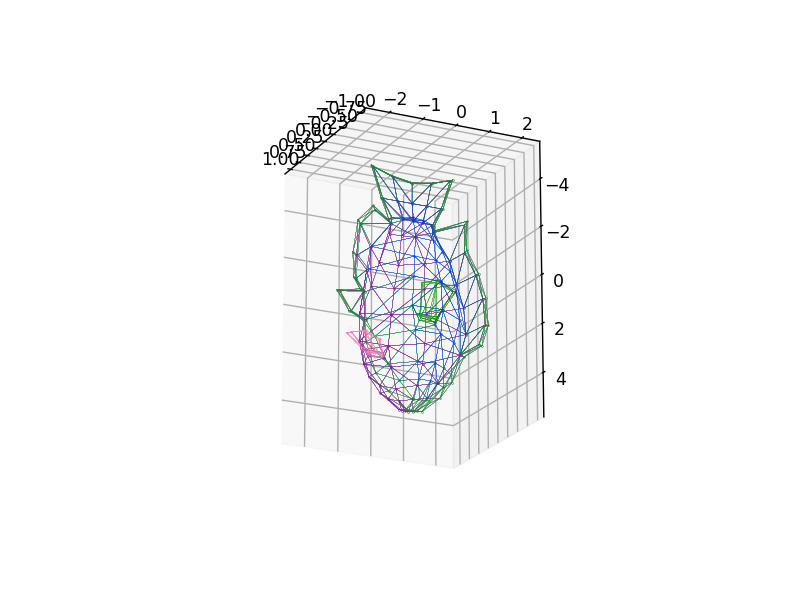

In [67]:
draw3d_multichart(chart_pointclouds_rabbit,0.005,0.05)

In [968]:
len(chart_pointclouds_rabbit)

5

In [1241]:
def face_correspond(points_chart,pc,face_total):
    indexes=[]
    for p in points_chart:
        indexes.append(p.index)
    # print(indexes)
    faces_chart=[]
    for face in face_total:
        # print(face)
#         if (face[0] in indexes):
#             point_temp=pc[face[0]]
#             if (pc[face[1]] in point_temp.neighbors) and (pc[face[2]] in point_temp.neighbors) and (face[1] in indexes) and (face[2] in indexes):
#                 faces_chart.append(face)
        if (face[0] in indexes) and (face[1] in indexes) and (face[2] in indexes):
            faces_chart.append(face)
        
    return faces_chart
            
    

In [1242]:
def save_uvs(pc):
    us=[]
    vs=[]
    for p in pc:
        uss=[]
        vss=[]
        for pn in p.neighbors:
            uss.append(pn.u)
            vss.append(pn.v)
        us.append(uss)
        vs.append(vss)
    return [us,vs]

In [1243]:
def draw_chart(pchart,point_size=0.01,line_width=0.001,color_v='b',color_e='r'):
    fig = plt.figure()
    ax = plt.axes()
    for point in pchart: 
        ax.scatter(point.u, point.v,s=point_size,c=color_v) 
        for i in range(len(p.nus)):
            ax.plot([point.u,p.nus[i]],[point.v,p.nvs[i]],c=color_e,linewidth=line_width)
    # ax.plot([pointcloud[0].x,pointcloud[3].x],[pointcloud[0].y,pointcloud[3].y],[pointcloud[0].z,pointcloud[3].z],c='g')
    ax.set_title('chart Scatter plot')
    plt.show()

In [1244]:
all_charts=[]
face_charts=[]
all_uvs=[]

In [1245]:
test=[i for i in set(chart_pointclouds_rabbit[0])]
ftest=face_correspond(test,pointcloud_rabbit,face_rabbit)


<IPython.core.display.Javascript object>


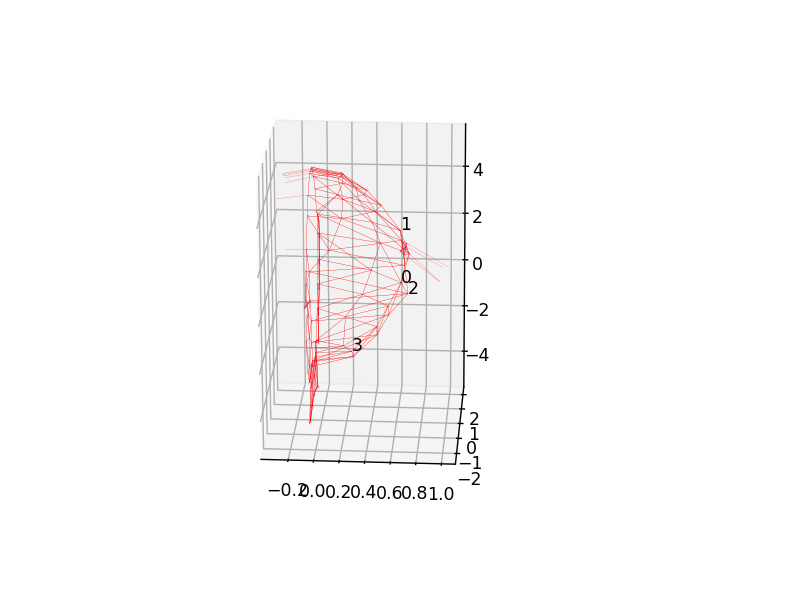

In [736]:
draw3d(test,0.001,0.1)

In [1246]:
dictionary={}
i=0
for point in test:
    dictionary[point.index]=i
    point.index=i
    
    i+=1
    
for f in ftest:
    for i in range(len(f)):
        a=f[i]
        b=dictionary[a]
        f[i]=b

In [1247]:
projection(test,test,ftest)
uvs=save_uvs(test)

In [1248]:
all_charts.append(test)
face_charts.append(ftest)
all_uvs.append(uvs)

<IPython.core.display.Javascript object>


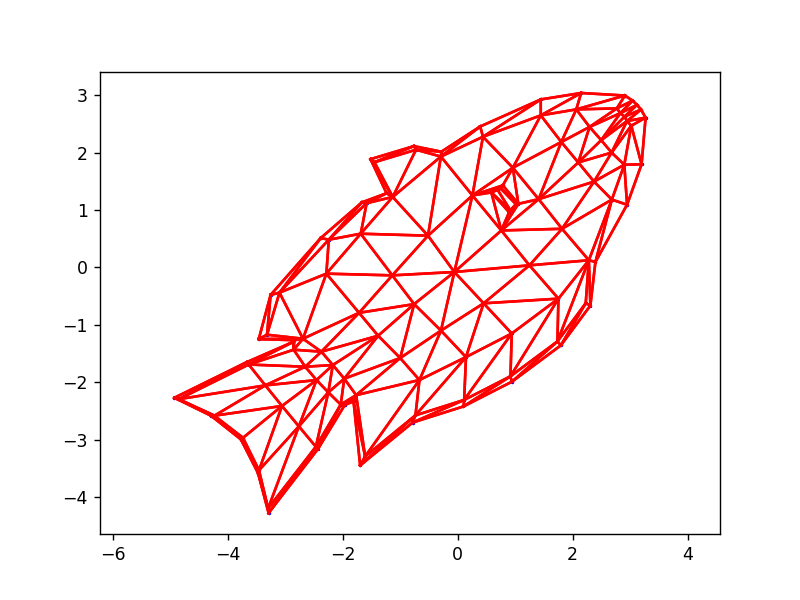

In [1039]:
draw(test)

<IPython.core.display.Javascript object>


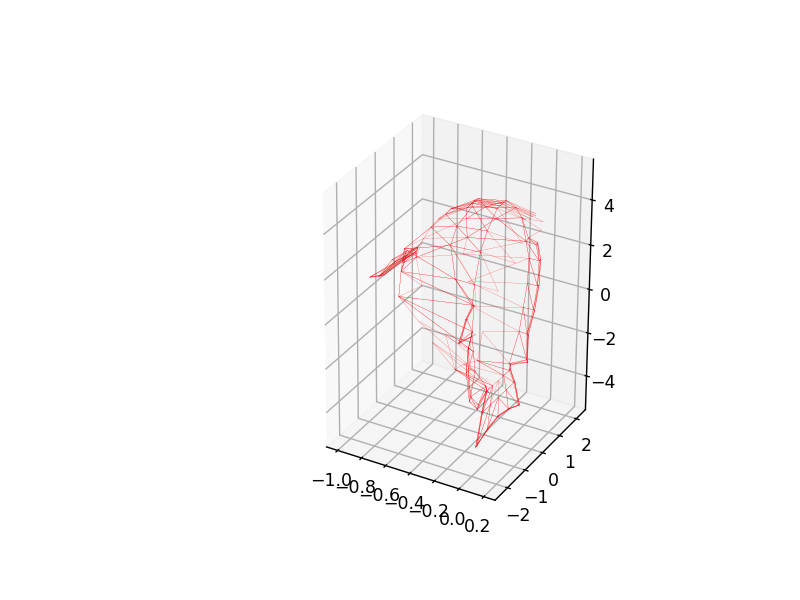

In [1249]:
test=[i for i in set(chart_pointclouds_rabbit[1])]
ftest=face_correspond(test,pointcloud_rabbit,face_rabbit)
draw3d(test,0.001,0.1)

In [1250]:
dictionary={}
i=0
for point in test:
    dictionary[point.index]=i
    point.index=i
    
    i+=1
    
for f in ftest:
    for i in range(len(f)):
        a=f[i]
        b=dictionary[a]
        f[i]=b

In [1251]:
projection(test,test,ftest)
uvs=save_uvs(test)

In [1252]:
all_charts.append(test)
face_charts.append(ftest)
all_uvs.append(uvs)

<IPython.core.display.Javascript object>


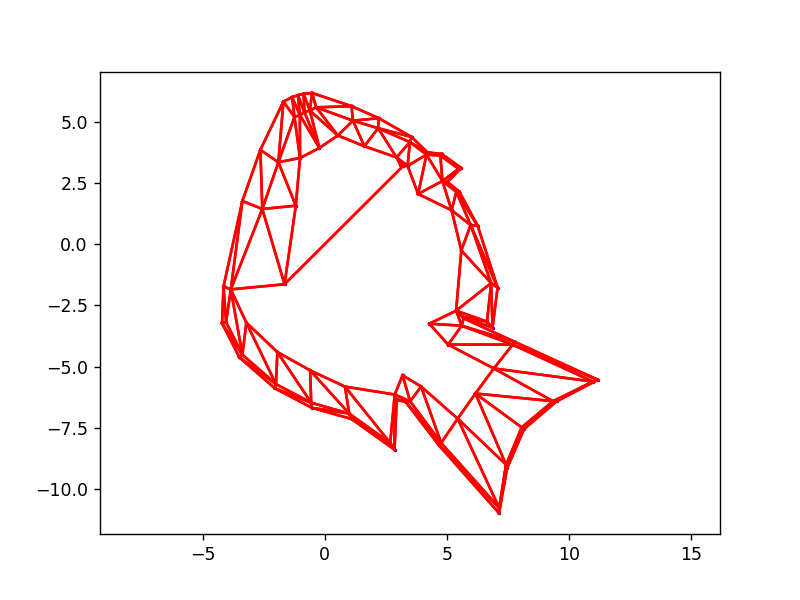

In [1098]:
draw(test)

In [1253]:
test=[i for i in set(chart_pointclouds_rabbit[2])]
ftest=face_correspond(test,pointcloud_rabbit,face_rabbit)

<IPython.core.display.Javascript object>


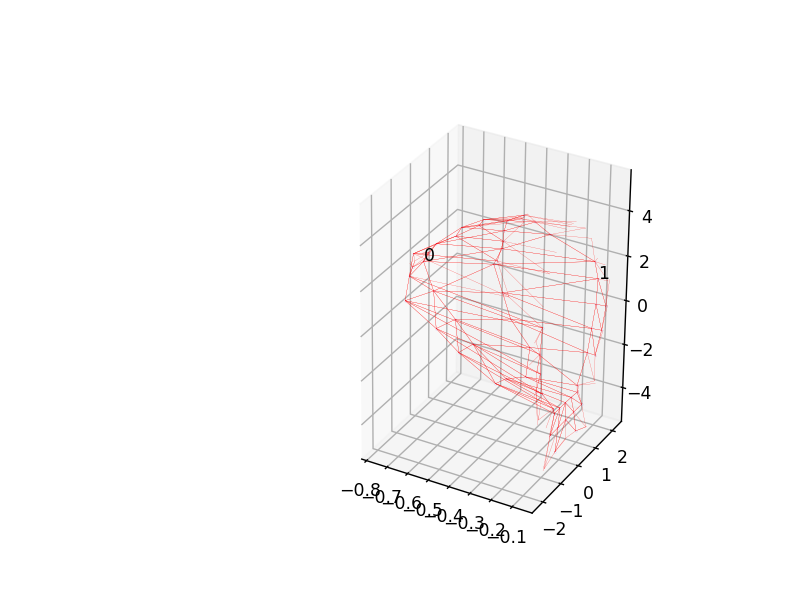

In [1100]:
draw3d(test,0.001,0.1)

In [1254]:
for p in test:
    for j in p.neighbors:
        if not j in test:
            p.neighbors.remove(j)
dictionary={}
i=0
for point in test:
    dictionary[point.index]=i
    point.index=i
    
    i+=1
    
for f in ftest:
    for i in range(len(f)):
        a=f[i]
        b=dictionary[a]
        f[i]=b

In [1255]:
projection(test,test,ftest)
uvs=save_uvs(test)

In [1256]:
all_charts.append(test)
face_charts.append(ftest)
all_uvs.append(uvs)

<IPython.core.display.Javascript object>


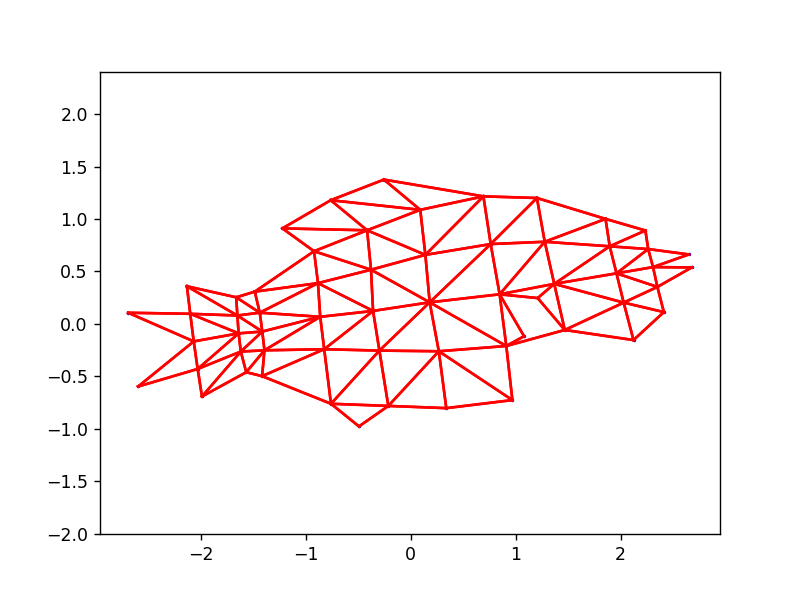

In [1159]:
draw(test)

<IPython.core.display.Javascript object>


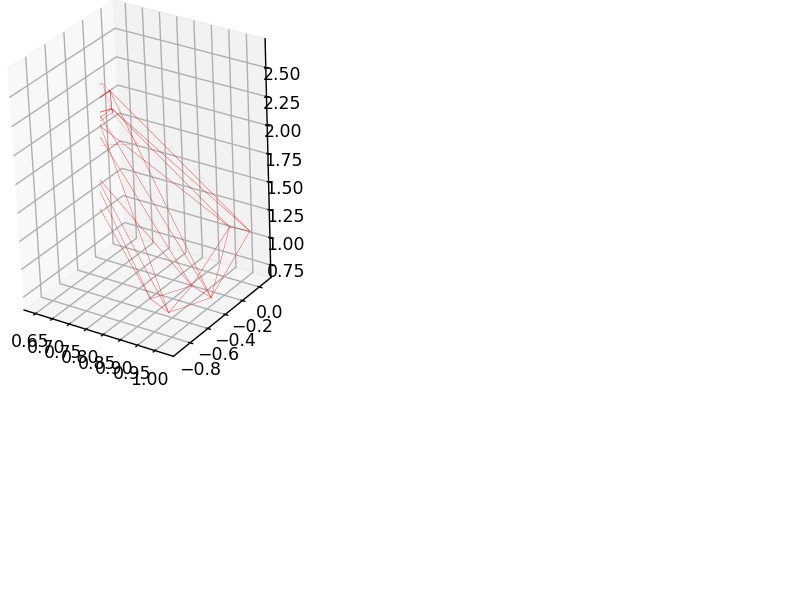

In [1257]:
test=[i for i in set(chart_pointclouds_rabbit[3])]
ftest=face_correspond(test,pointcloud_rabbit,face_rabbit)
draw3d(test,0.001,0.1)

In [1258]:
dictionary={}
i=0
for point in test:
    dictionary[point.index]=i
    point.index=i
    
    i+=1
    
for f in ftest:
    for i in range(len(f)):
        a=f[i]
        b=dictionary[a]
        f[i]=b
        
projection(test,test,ftest)
uvs=save_uvs(test)

all_charts.append(test)
face_charts.append(ftest)
all_uvs.append(uvs)

<IPython.core.display.Javascript object>


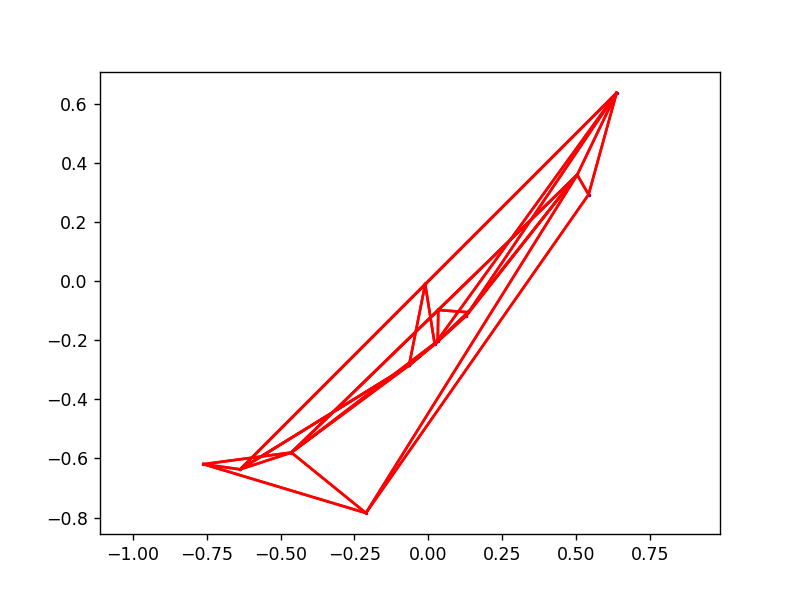

In [1161]:
draw(test)

<IPython.core.display.Javascript object>


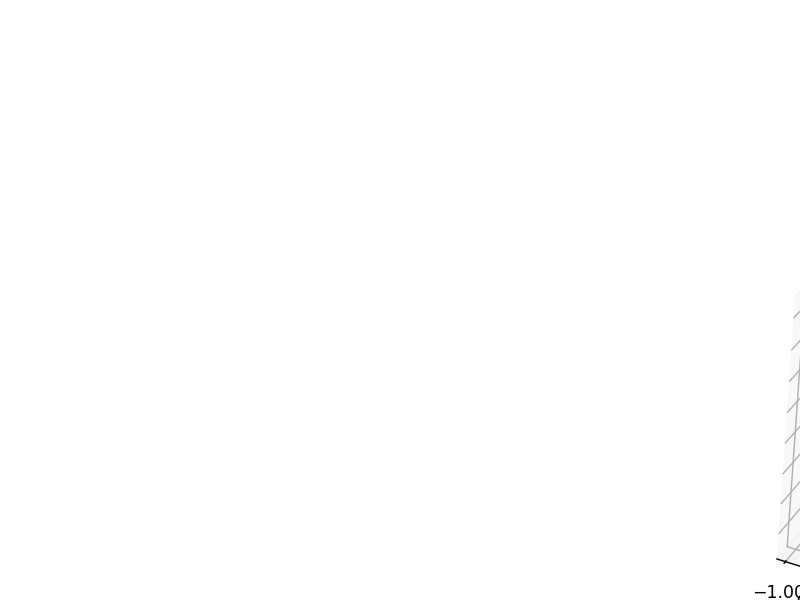

In [1259]:
test=[i for i in set(chart_pointclouds_rabbit[4])]
ftest=face_correspond(test,pointcloud_rabbit,face_rabbit)
draw3d(test,0.001,0.1)

In [1260]:
dictionary={}
i=0
for point in test:
    dictionary[point.index]=i
    point.index=i
    
    i+=1
    
for f in ftest:
    for i in range(len(f)):
        a=f[i]
        b=dictionary[a]
        f[i]=b
        
projection(test,test,ftest)
uvs=save_uvs(test)

all_charts.append(test)
face_charts.append(ftest)
all_uvs.append(uvs)

<IPython.core.display.Javascript object>


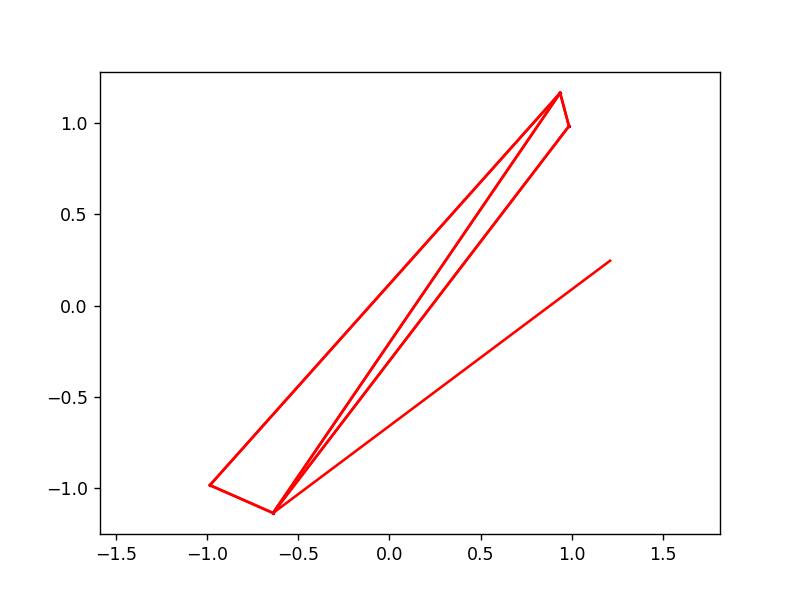

In [1163]:
draw(test)

In [1261]:
def diameter_pc(pointcloud):
    pts=[]
    for point in pointcloud:
        pts.append([point.u,point.v])
    # print(pts)
    # print(spatial.ConvexHull(pts).vertices[0])
    candidates = [pts[i] for i in spatial.ConvexHull(pts, qhull_options="QJ").vertices]
    us=[]
    vs=[]
    for i in candidates:
        us.append(i[0])
        vs.append(i[1])
    dist_mat = spatial.distance_matrix(candidates, candidates)
    # print(candidates[1])
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    return [candidates[i][0],candidates[i][1],candidates[j][0],candidates[j][1]]

In [1262]:
def rotate(pointcloud):
    u1,v1,u2,v2=diameter_pc(pointcloud)
    angle=np.arctan((u2-u1)/(v2-v1))
    # print(angle)
    pointsx=[]
    pointsy=[]
    for p in pointcloud:
        cx=np.cos(angle)*p.u-np.sin(angle)*p.v
        cy=np.sin(angle)*p.u+np.cos(angle)*p.v
        p.u=cx
        p.v=cy
    # return pointsx,pointsy

In [1263]:
for c in all_charts:
    rotate(c)

In [1264]:
def collect_coords(charts):
    total_coords=[]
    for chart in charts:
        coordu=[]
        coordv=[]
        for p in chart:
            coordu.append(p.u)
            coordv.append(p.v)
        total_coords.append([coordu,coordv])
    return total_coords

In [1265]:
uv_charts=collect_coords(all_charts)

In [1266]:
colors=['r','g','b','y','c']
#colors=['#FF0000','#800080','#2E8B57','#EE82EE','#FFA500','#32CD32','#FF1493','#A9A9A9','#BDB76B','#000000','#00FFFF','#F0F8FF','#DC143C','#9400D3','#B22222','#DAA520']

In [1267]:
def draw_uv(chart,color='b',pointsize=0.4):
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(chart[0],chart[1],s=pointsize,c=color)
    ax.axis("equal") 
    plt.show()

In [1268]:
def corner(chart):
    minx=min(chart[0])
    miny=min(chart[1])
    maxx=max(chart[0])
    maxy=max(chart[1])
    return minx,miny,maxx,maxy

In [1269]:
def create_packing(charts):
    lx=0
    ly=0
    rects=[]
    for chart in charts:
        minx,miny,maxx,maxy=corner(chart)
        # print(maxx-minx)
        # print(maxy-miny)
        rects.append((maxx-minx,maxy-miny))
        lx+=maxx-minx
        ly+=maxy-miny
    
    lx/=2
    ly/=2
    return rects,[lx,ly]

In [1270]:
rectangle,area=create_packing(uv_charts)

In [1271]:
def solve_packing(rects):
    problem = rps.Problem(rectangles=rects)
    solution = rps.Solver().solve(problem=problem)
    return solution

In [1272]:
solution_uv=solve_packing(rectangle)

In [1273]:
def adjust_coords(charts,solution):
    for i in range(len(charts)):
        chart=charts[i]
        minx,miny,maxx,maxy=corner(chart)
        info=solution.floorplan.positions[i]
        for j in range(len(chart[0])):
            chart[0][j]+=(info["x"]-minx)
        for j in range(len(chart[1])):
        
            chart[1][j]+=(info["y"]-miny)

In [1274]:
adjust_coords(uv_charts,solution_uv)

In [1275]:
def draw_all_charts(charts,colors,pointsize=0.4):
    fig = plt.figure()
    ax = plt.axes()
    for i in range(len(charts)):
        chart=charts[i]
        ax.scatter(chart[0],chart[1],s=pointsize,c=colors[i])
    ax.axis("equal")  
    plt.show()

<IPython.core.display.Javascript object>


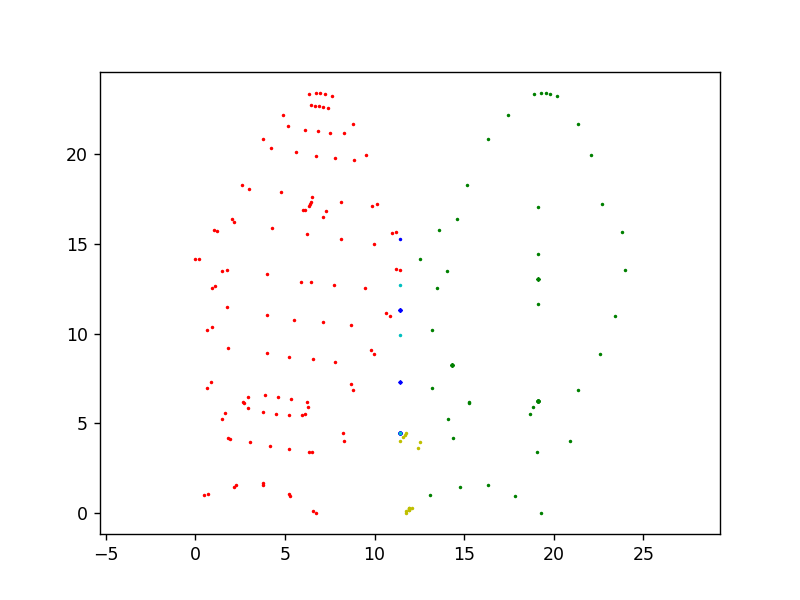

In [1279]:
draw_all_charts(uv_charts,colors,pointsize=1.0)

In [1280]:
def corner_uv(chart):
    xx=[p.u for p in chart]
    yy=[p.v for p in chart]
    minx=min(xx)
    miny=min(yy)
    maxx=max(xx)
    maxy=max(yy)
    return minx,miny,maxx,maxy

In [1281]:
def create_packing_uv(charts):
    lx=0
    ly=0
    rects=[]
    for chart in charts:
        minx,miny,maxx,maxy=corner_uv(chart)
        # print(maxx-minx)
        # print(maxy-miny)
        rects.append((maxx-minx,maxy-miny))
        lx+=maxx-minx
        ly+=maxy-miny
    
    lx/=2
    ly/=2
    return rects,[lx,ly]

In [1282]:
rectangle_uv,area_uv=create_packing_uv(all_charts)
solution_uv_rabbit=solve_packing(rectangle_uv)

In [1283]:
def adjust_coords_uv(charts,solution):
    for i in range(len(charts)):
        chart=charts[i]
        minx,miny,maxx,maxy=corner_uv(chart)
        info=solution.floorplan.positions[i]
        for p in chart:
            p.u+=(info["x"]-minx)
            p.v+=(info["y"]-miny)

In [1284]:
adjust_coords_uv(all_charts,solution_uv_rabbit)

In [1285]:
def draw_final(charts,pointsize=2,draw_lines=True,text=False):
    fig = plt.figure()
    ax = plt.axes()
    for i in range(len(charts)):
        print(i)
        chart=charts[i]
        indexes=[]
        for p in chart:
            ax.scatter(p.u,p.v,s=pointsize,c='b')
            indexes.append(p.index)
            if draw_lines:
                for nei in p.neighbors:
                    ax.plot([p.u,nei.u],[p.v,nei.v],c='r',linewidth=0.1)
#             if text:
#                 ax.text(point.u,point.v,point.index)
    ax.axis("equal") 
    plt.show()
    